In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import scipy.stats

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve
from joblib import dump


In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/Final_data/train.csv')


In [3]:
train_df.shape

(26570, 26)

In [4]:
train_df.describe()

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26570.000000,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,...,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,13284.500000,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,...,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,7670.242662,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,...,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,0.000000,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,...,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,6642.250000,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,...,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,13284.500000,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,...,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,19926.750000,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,...,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,26569.000000,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,...,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


In [5]:
train_df.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [6]:
print("Name\tUnique values\tIn %")
for column in train_df.columns:
    print(f"{column}\t{train_df[column].nunique()}\t{round(train_df[column].nunique()/len(train_df)*100,2)}")

Name	Unique values	In %
id	26570	100.0
product_code	5	0.02
loading	11950	44.98
attribute_0	2	0.01
attribute_1	3	0.01
attribute_2	4	0.02
attribute_3	4	0.02
measurement_0	29	0.11
measurement_1	30	0.11
measurement_2	25	0.09
measurement_3	4721	17.77
measurement_4	4692	17.66
measurement_5	4671	17.58
measurement_6	4704	17.7
measurement_7	4734	17.82
measurement_8	4713	17.74
measurement_9	4708	17.72
measurement_10	6177	23.25
measurement_11	6526	24.56
measurement_12	6392	24.06
measurement_13	5271	19.84
measurement_14	6389	24.05
measurement_15	6577	24.75
measurement_16	7035	26.48
measurement_17	23612	88.87
failure	2	0.01


In [7]:
train_df.product_code.unique()

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

In [8]:
train_df.dtypes

id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object

In [9]:
print(train_df.columns)

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')


In [10]:
print('Train data missing value is = {} %'.format(100* train_df.isna().sum().sum()/(len(train_df)*25)))



Train data missing value is = 3.052013549115544 %


In [11]:
float_cols = [f for f in train_df.columns if train_df[f].dtype == float]

In [12]:
print(f"{train_df[float_cols].isna().any(axis=1).sum() / len(train_df):.0%}")

54%


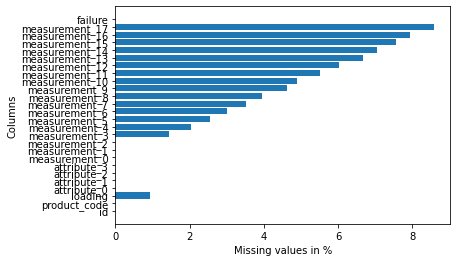

In [13]:
percent = []
for column in train_df.columns:
    percent.append( train_df[column].isna().sum()/len(train_df)*100)

plt.barh(y=train_df.columns, width=percent, label='s');
plt.xlabel("Missing values in %")
plt.ylabel("Columns")
plt.show()

In [14]:
print(train_df.failure.value_counts() / len(train_df))

0    0.787392
1    0.212608
Name: failure, dtype: float64


In [15]:
print(train_df.columns)


Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')


In [16]:
from sklearn.preprocessing import LabelEncoder
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

auc_list = []
kf = GroupKFold(n_splits=5)
best_auc = 0
for fold, (index_train, index_val) in enumerate(kf.split(train_df, train_df.failure, train_df.product_code)):
    xTrain = train_df.iloc[index_train]
    xVal = train_df.iloc[index_val]
    yTrain = train_df.iloc[index_train].failure
    yVal = train_df.iloc[index_val].failure

    #label encode attribute_0 and attribute_1
    for col in ['attribute_0', 'attribute_1']:
        le = LabelEncoder()
        le.fit(pd.concat([xTrain[col], xVal[col]], ignore_index=True))
        
        #transform the training and validation data using the fitted label encoder
        xTrain[col] = le.transform(xTrain[col])
        xVal[col] =le.transform(xVal[col])

        
    xTrain['m3_flag'] = xTrain.measurement_3.isna()
    xVal['m3_flag'] = xVal.measurement_3.isna()
    xTrain['m5_flag'] = xTrain.measurement_5.isna()
    xVal['m5_flag'] = xVal.measurement_5.isna()
        
    # use imputer to impute the missing values.
    features = []
    for feature in xTrain.columns:
        if feature == 'loading' or feature.startswith('measurement'):
            features.append(feature)
    imputer = KNNImputer(n_neighbors=15)
    #imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(xTrain[features])
    xTrain[features] = imputer.transform(xTrain[features])
    xVal[features] = imputer.transform(xVal[features])
                


    # X_tr['measurement_2'] = X_tr['measurement_2'].clip(11, None)
    # X_va['measurement_2'] = X_va['measurement_2'].clip(11, None)

    #select feature that we want to fit model
    feature_selection = ['loading', 'attribute_3', 'measurement_2', 'measurement_4', 'measurement_17', 'm3_flag', 'm5_flag']


    #model = LogisticRegression()
    #model = make_pipeline(StandardScaler(), LogisticRegression())
    model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', C=0.01,solver='liblinear', random_state=1,class_weight='balanced'))
    model.fit(xTrain[feature_selection], yTrain)


    # validate and count auc
    yVal_pred = model.predict_proba(xVal[feature_selection])[:,1]
    score = roc_auc_score(yVal, yVal_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)

    # if score > best_auc:
    #   best_auc = score
dump(model, '/content/drive/MyDrive/Final_data/model.joblib')


print(f"Mean auc = {np.mean(auc_list):.5f}")

    
   


Fold 0: auc = 0.58820
Fold 1: auc = 0.58157
Fold 2: auc = 0.59066
Fold 3: auc = 0.59680
Fold 4: auc = 0.59662
Mean auc = 0.59077
